In [1]:
import numpy as np 
import pandas as pd

import plotly
import geopandas 
# import pyshp 
import shapely
import matplotlib.pyplot as plt

import plotly.figure_factory as ff

import requests
import json

import prettytable

import time

import warnings

from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

An issue that we have run into is that for our most important y outcome metric (labor force participation, we only have the actual number of people in the labor force per month per FIPS. As such, we need a metric which is the total population of the county by month in order to get a LFP rate!


We attempt to use ML methods to take the annual population counts for each FIP from 2009 to 2020 and turn them into a monthly interpolation from 2018 Jan until 2022 May! 

In [2]:
census_pop_vars = [
                  'B01001_001E', #full pop, 
                  
                  'B01001_003E', #male under 5, 
                  'B01001_004E', #male 5-9 
                  'B01001_005E', #male 10-14
                  'B01001_006E', #male under 15-17
                  
                  'B01001_027E', #female under 5, 
                  'B01001_028E', #female under 5-9, 
                  'B01001_029E', #female under 10-14, 
                  'B01001_030E', #female under 15-17, 
                 ]

In [3]:
time_0 = time.time()
year_dfs = {}

years = [str(x) for x in range(2009,2021)]
for year in years:
    
    year_specific = \
        pd.read_json('https://api.census.gov/data/{}/acs/acs5?get=NAME,{}&for=county:*&in=state:*'.format(year, ','.join(census_pop_vars)))
    year_specific.columns = year_specific.iloc[0]
    year_specific = year_specific.iloc[1:]
    year_specific['year'] = year
    year_specific['FIPS'] = year_specific['state'] + year_specific['county']
    
    for var in census_pop_vars:
        year_specific[var] = pd.to_numeric(year_specific[var], errors = 'coerce')
    year_specific['LF_' + str(year)] = (year_specific['B01001_001E'] - year_specific['B01001_003E'] -
        year_specific['B01001_004E'] - year_specific['B01001_005E'] -
        year_specific['B01001_006E'] * (1/3) - year_specific['B01001_027E'] - 
        year_specific['B01001_028E'] - year_specific['B01001_029E'] - 
        year_specific['B01001_030E'] * (1/3))
    
    year_specific.set_index('FIPS', inplace=True)
    
    year_dfs[year] = year_specific 
    print("Finished: ", year, round(time.time() - time_0, 2))
    time_0 = time.time()
    
to_concat = [df_i[['LF_'+year_i]] for year_i, df_i in year_dfs.items()]
LF = pd.concat(to_concat, axis = 1)
LF.columns = [x[3:] for x in LF.columns]
LF.columns = [pd.Timestamp(year = int(x), month = 1, day = 1) for x in LF.columns]
LF.head(2)

Finished:  2009 1.13
Finished:  2010 1.17
Finished:  2011 1.15
Finished:  2012 1.21
Finished:  2013 1.85
Finished:  2014 1.61
Finished:  2015 1.15
Finished:  2016 1.96
Finished:  2017 1.21
Finished:  2018 1.03
Finished:  2019 1.09
Finished:  2020 1.33


,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01
FIPS,,,,,,,,,,,,
13091,15657.666667,17236.333333,17279.666667,17245.666667,17398.333333,17375.666667,17178.0,17103.000000,17246.666667,17210.333333,17185.000000,17175.666667
13093,9257.000000,11417.000000,11617.666667,11758.333333,11888.666667,11793.333333,11726.0,11678.333333,11802.333333,11706.333333,11631.666667,11568.666667


Now, we want to predict the intermonth month values, assuming that the data is from the start of the period, and then forecast for the next couple of years. In order to do this, we first convert from timestamps to integers. 

In [4]:
def dt_to_int(dt_in):
    return(dt_in.year - 2009) * 12 + dt_in.month

def int_to_dt(int_in): 
    day = 1 
    month = int(int_in % 12)
    if month == 0: 
        month = 12
        
    year = int(np.floor((int_in-1) / 12) + 2009)
    return pd.Timestamp(year = year, month = month, day = day)

In [5]:
X_train = np.array([dt_to_int(x) for x in LF.columns])
X_train = sm.add_constant(X_train)
X_train;

In [6]:
to_predict = []

for year in range(2009, 2023):
    for month in range(1, 13):
        value_to_add = pd.Timestamp(year = year, month = month, day = 1)
        if value_to_add not in LF.columns:
            to_predict.append(value_to_add)

to_predict = np.array(to_predict[:-7])

to_predict = np.array([dt_to_int(x) for x in to_predict])
to_predict = sm.add_constant(to_predict)
to_predict;

In [7]:
y_train = LF.transpose().values
y_train;

In [8]:
model_predictions = sm.OLS(y_train, X_train).fit().predict(to_predict)
model_predictions_df = pd.DataFrame(model_predictions).transpose()
model_predictions_df.columns = [y for x,y in to_predict]
model_predictions_df.rename(columns = int_to_dt, inplace=True)
model_predictions_df.index = LF.index
model_predictions_df

,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,...,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01
FIPS,,,,,,,,,,,,,,,,,,,,,
13091,16829.787879,16834.062937,16838.337995,16842.613054,16846.888112,16851.163170,16855.438228,16859.713287,16863.988345,16868.263403,...,17471.046620,17475.321678,17479.596737,17483.871795,17488.146853,17492.421911,17496.696970,17500.972028,17505.247086,17509.522145
13093,10966.227273,10974.240870,10982.254468,10990.268065,10998.281663,11006.295260,11014.308858,11022.322455,11030.336053,11038.349650,...,12168.266900,12176.280497,12184.294095,12192.307692,12200.321290,12208.334887,12216.348485,12224.362082,12232.375680,12240.389277
13095,73301.821970,73280.972999,73260.124029,73239.275058,73218.426088,73197.577117,73176.728147,73155.879176,73135.030206,73114.181235,...,70174.476399,70153.627428,70132.778458,70111.929487,70091.080517,70070.231546,70049.382576,70028.533605,70007.684635,69986.835664
13097,93218.840909,93367.207459,93515.574009,93663.940559,93812.307110,93960.673660,94109.040210,94257.406760,94405.773310,94554.139860,...,115473.823427,115622.189977,115770.556527,115918.923077,116067.289627,116215.656177,116364.022727,116512.389277,116660.755828,116809.122378
13099,8730.558081,8724.299922,8718.041764,8711.783605,8705.525447,8699.267288,8693.009130,8686.750971,8680.492813,8674.234654,...,7791.834305,7785.576146,7779.317988,7773.059829,7766.801671,7760.543512,7754.285354,7748.027195,7741.769037,7735.510878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72131,35218.369949,35181.167249,35143.964549,35106.761849,35069.559149,35032.356449,34995.153749,34957.951049,34920.748349,34883.545649,...,29637.964938,29600.762238,29563.559538,29526.356838,29489.154138,29451.951437,29414.748737,29377.546037,29340.343337,29303.140637
46102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pd.concat([LF, model_predictions_df], axis = 1).sort_index(axis = 1).head()

,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,...,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01
FIPS,,,,,,,,,,,,,,,,,,,,,
13091,15657.666667,16829.787879,16834.062937,16838.337995,16842.613054,16846.888112,16851.163170,16855.438228,16859.713287,16863.988345,...,17471.046620,17475.321678,17479.596737,17483.871795,17488.146853,17492.421911,17496.696970,17500.972028,17505.247086,17509.522145
13093,9257.000000,10966.227273,10974.240870,10982.254468,10990.268065,10998.281663,11006.295260,11014.308858,11022.322455,11030.336053,...,12168.266900,12176.280497,12184.294095,12192.307692,12200.321290,12208.334887,12216.348485,12224.362082,12232.375680,12240.389277
13095,72737.000000,73301.821970,73280.972999,73260.124029,73239.275058,73218.426088,73197.577117,73176.728147,73155.879176,73135.030206,...,70174.476399,70153.627428,70132.778458,70111.929487,70091.080517,70070.231546,70049.382576,70028.533605,70007.684635,69986.835664
13097,90492.000000,93218.840909,93367.207459,93515.574009,93663.940559,93812.307110,93960.673660,94109.040210,94257.406760,94405.773310,...,115473.823427,115622.189977,115770.556527,115918.923077,116067.289627,116215.656177,116364.022727,116512.389277,116660.755828,116809.122378
13099,8956.666667,8730.558081,8724.299922,8718.041764,8711.783605,8705.525447,8699.267288,8693.009130,8686.750971,8680.492813,...,7791.834305,7785.576146,7779.317988,7773.059829,7766.801671,7760.543512,7754.285354,7748.027195,7741.769037,7735.510878


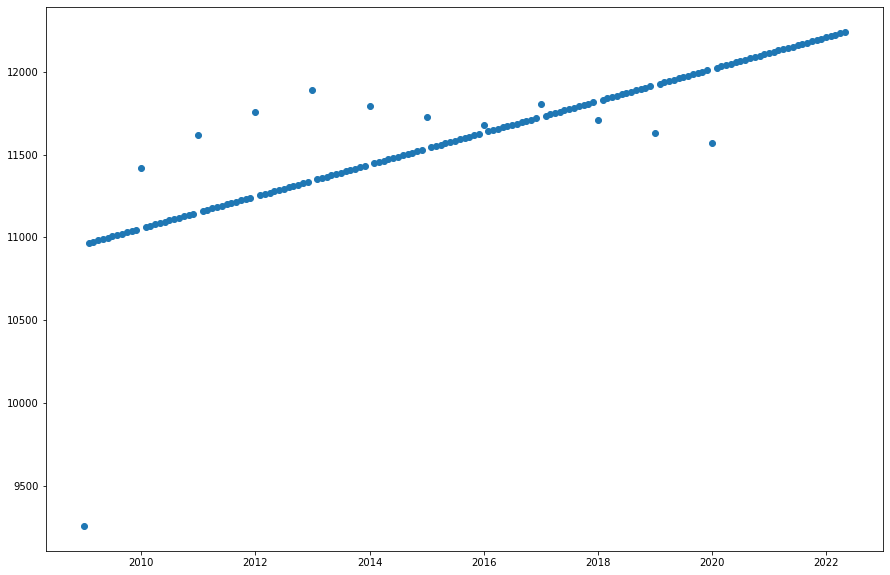

In [11]:
#this is a large and very glaring error! 
y = pd.concat([LF, model_predictions_df], axis = 1).sort_index(axis = 1).iloc[1].index 
x = pd.concat([LF, model_predictions_df], axis = 1).sort_index(axis = 1).iloc[1].values

plt.figure(figsize = (15,10))
plt.scatter(y, x)

In [20]:
melted = pd.melt(pd.concat([LF, model_predictions_df], axis = 1).sort_index(axis = 1).reset_index(), id_vars = ['FIPS']).rename({'variable': 'date', 'value':'LF_pop'}, axis = 1).set_index(['FIPS', 'date'])
melted
melted.to_csv('/Users/zachmariani/ECMA/ECMA_Final_Project/Data/Census_C/monthly_pop_figures.csv')